# Imports and Constants

In [1]:
import sys
# sys.path is a list of absolute path strings
sys.path.append('..')

import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd 
import pickle
import seaborn as sns 
import time
from tqdm import tqdm

import rhythm_regression.vector_processing as vp
import rhythm_regression.notebook_tools as nbt
from generate_model_data import *
from data_gen_constants import *

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

PLOT_WIDTH = 300

# Load Data

In [2]:
print('Loading examples')
train_examples, val_examples, test_examples = load_example_data()

print('Loading statistics')
train_stats = pd.read_csv(os.path.join(DATA_DIR, TRAIN_STATS_FILENAME), index_col=0)
val_stats = pd.read_csv(os.path.join(DATA_DIR, VAL_STATS_FILENAME), index_col=0)
test_stats = pd.read_csv(os.path.join(DATA_DIR, TEST_STATS_FILENAME), index_col=0)
print(f'Number of training blocks {len(train_stats)}')
print(f'Number of validation blocks {len(val_stats)}')
print(f'Number of testing blocks {len(test_stats)}')

print('Loading data generating parameters')
train_params = pd.read_csv(os.path.join(DATA_DIR, TRAIN_PARAMS_FILENAME), index_col=0)
val_params = pd.read_csv(os.path.join(DATA_DIR, VAL_PARAMS_FILENAME), index_col=0)
test_params = pd.read_csv(os.path.join(DATA_DIR, TEST_PARAMS_FILENAME), index_col=0)
print(f'Number of training params {len(train_params)}')
print(f'Number of validation params {len(val_params)}')
print(f'Number of testing params {len(test_params)}')


total_memory = sys.getsizeof(train_examples) + sys.getsizeof(val_examples) + sys.getsizeof(test_examples) + \
               sys.getsizeof(train_stats) + sys.getsizeof(val_stats) + sys.getsizeof(test_stats) + \
               sys.getsizeof(train_params) + sys.getsizeof(val_params) + sys.getsizeof(test_params)
print(f'Total memory: {total_memory}')


Loading examples
Number of training examples: 500
Number of validation examples: 300
Number of testing examples: 200
Loading statistics
Number of training blocks 25000
Number of validation blocks 15000
Number of testing blocks 10000
Loading data generating parameters
Number of training params 500
Number of validation params 300
Number of testing params 200
Total memory: 7656432


In [3]:
train_examples[0].keys()

dict_keys(['id', 'm', 't', 'm_diff', 't_diff', 'm_diff2', 't_diff2', 'matchings'])

In [4]:
train_params.head()

,deletion_rate,insertion_rate,len_m,space_augmentation_rate,space_reduction_rate
example_id,,,,,
0,0.04,0.3,300,0.003,0.005
1,0.30,0.5,200,0.020,0.002
2,0.00,0.5,300,0.010,0.003
3,0.00,0.1,300,0.003,0.004
4,0.03,0.3,100,0.050,0.002


# Data Exploration

In [5]:
EDA_EXAMPLE = train_examples[4]

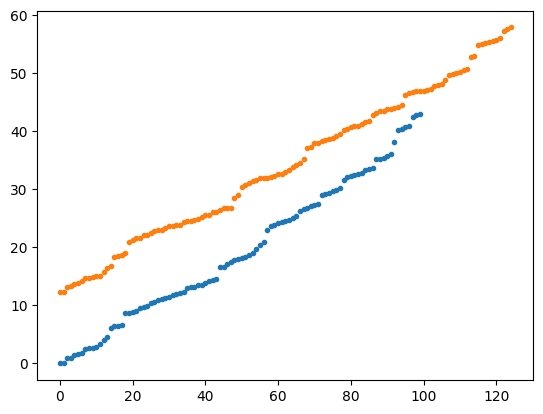

In [6]:
plt.plot(range(min(PLOT_WIDTH, len(EDA_EXAMPLE['m']))), EDA_EXAMPLE['m'][0 : PLOT_WIDTH], '.')
plt.plot(range(min(PLOT_WIDTH, len(EDA_EXAMPLE['t']))), EDA_EXAMPLE['t'][0 : PLOT_WIDTH], '.')

<BarContainer object of 124 artists>

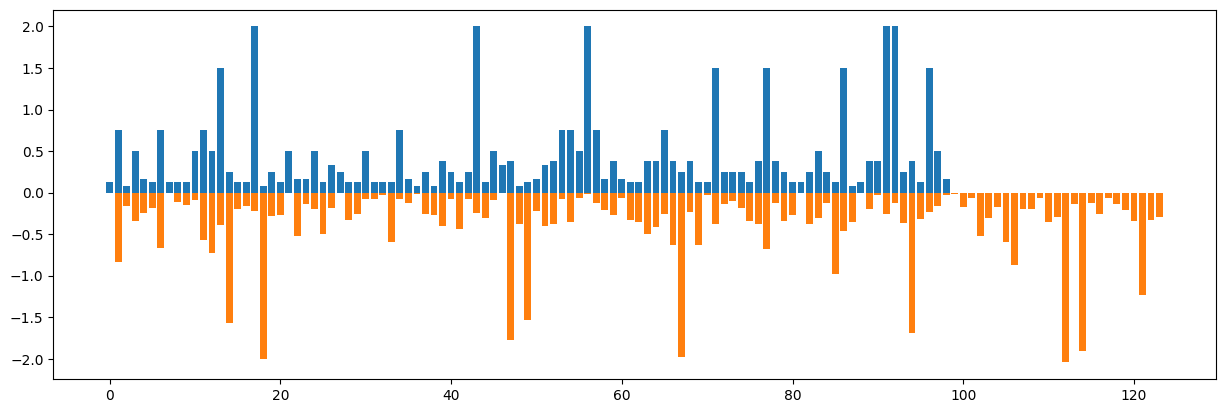

In [7]:
plt.figure(figsize = (15, 4.8))
plt.bar(range(min(PLOT_WIDTH, len(EDA_EXAMPLE['m_diff']))), EDA_EXAMPLE['m_diff'][0 : PLOT_WIDTH])
plt.bar(range(min(PLOT_WIDTH, len(EDA_EXAMPLE['t_diff']))), -1 * EDA_EXAMPLE['t_diff'][0 : PLOT_WIDTH])

<BarContainer object of 123 artists>

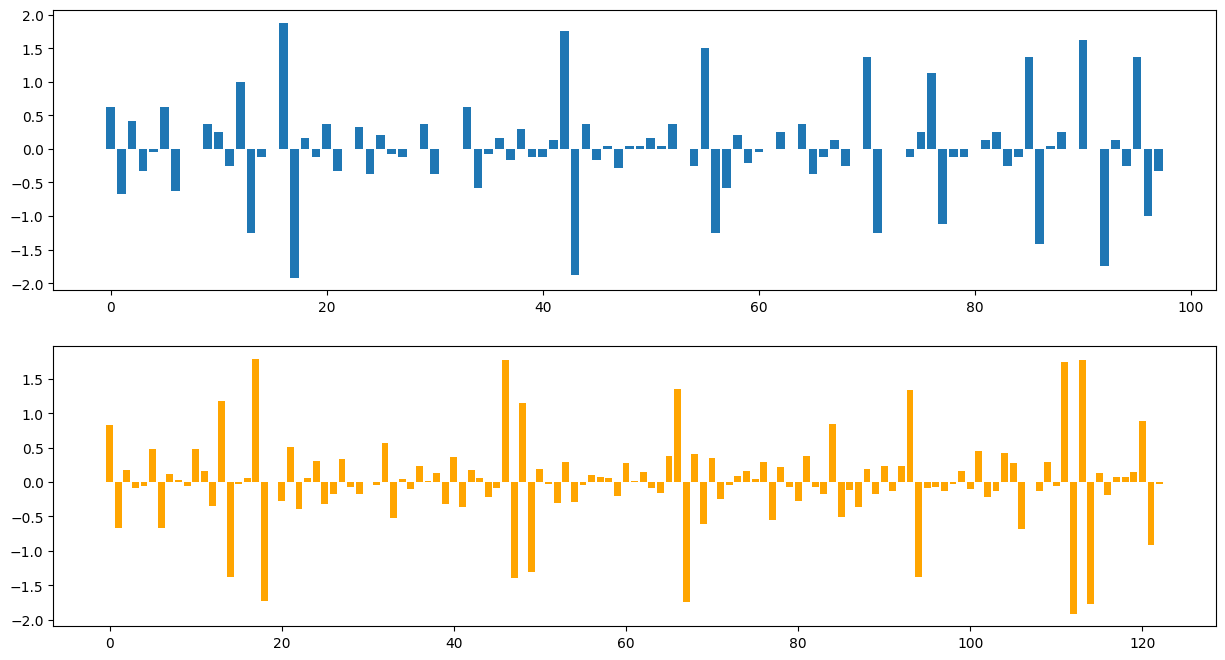

In [8]:
fig, (ax1, ax2) = plt.subplots(2)
fig.set_size_inches(15, 8)
ax1.bar(range(min(PLOT_WIDTH, len(EDA_EXAMPLE['m_diff2']))), EDA_EXAMPLE['m_diff2'][0 : PLOT_WIDTH])
ax2.bar(range(min(PLOT_WIDTH, len(EDA_EXAMPLE['t_diff2']))), EDA_EXAMPLE['t_diff2'][0 : PLOT_WIDTH], color='orange')

Total error: 27.694939409377724


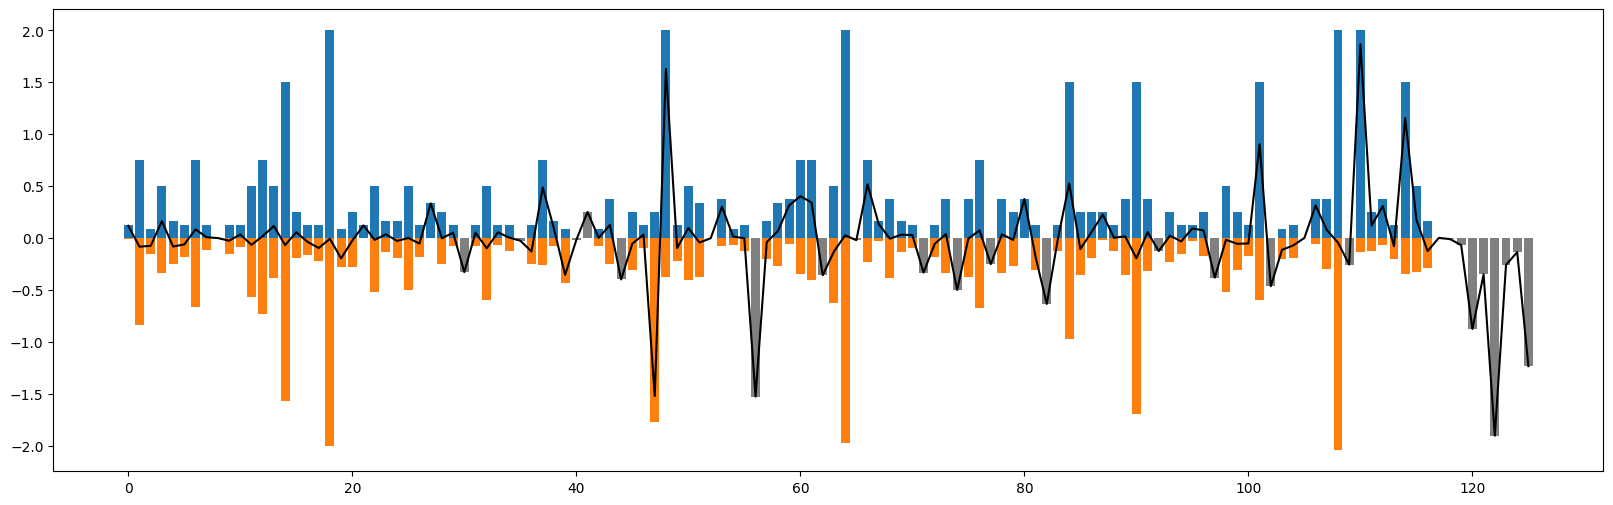

In [9]:
def get_matched_bar_plots(example):

    #print(f'{len(example["matchings"])=}')
    #print(f'{len(example["m"])=}')
    #print(f'{len(example["m_diff"])=}')
    #print(f'{len(example["t"])=}')
    #print(f'{len(example["t_diff"])=}')

    m_matched = [] 
    t_matched = [] 
    m_bar_colors = []
    t_bar_colors = []

    max_m_bar = max(example['m_diff'])
    max_t_bar = max(example['t_diff'])

    for i in range(len(example['matchings'])):
        mi, ti = example['matchings'][i]

        if mi is None or mi >= len(example['m_diff']):
            m_matched.append(0)
            t_bar_colors.append('grey')
        else:
            m_matched.append(example['m_diff'][mi])
            t_bar_colors.append('tab:orange')

        if ti is None or ti >= len(example['t_diff']):
            t_matched.append(0)
            m_bar_colors.append('grey')
        else:
            t_matched.append(example['t_diff'][ti])
            m_bar_colors.append('tab:blue')

    assert(len(m_matched) == len(t_matched))

    m_matched = np.array(m_matched)
    t_matched = np.array(t_matched)

    error = m_matched - t_matched
    print(f'Total error: {np.abs(error).sum()}')

    plt.figure(figsize=(20, 6))
    plt.bar(range(len(m_matched)), m_matched, color=m_bar_colors)
    plt.bar(range(len(t_matched)), -1 * t_matched, color=t_bar_colors)
    plt.plot(error, color='k')

    return m_matched, t_matched

m_bars, t_bars = get_matched_bar_plots(EDA_EXAMPLE)

<AxesSubplot: >

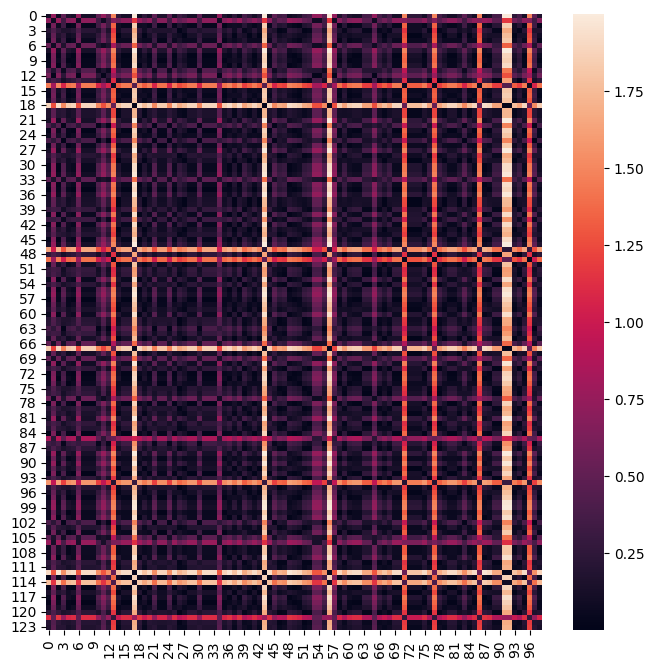

In [10]:
error_table = np.empty(shape=(len(EDA_EXAMPLE['t_diff']), len(EDA_EXAMPLE['m_diff'])))
for i in range(error_table.shape[0]):
    for j in range(error_table.shape[1]):
        error_table[i][j] = abs(EDA_EXAMPLE['t_diff'][i] - EDA_EXAMPLE['m_diff'][j])


plt.figure(figsize=(8,8))
sns.heatmap(error_table)

# Algorithm Definition and Testing

In [11]:
def get_min_cost_dp(cost_matrix):

    width = cost_matrix.shape[0]
    height = cost_matrix.shape[1]

    min_cost_sum = [[None for i in range(height)] for j in range(width)]
    matchings = [[None for i in range(height)] for j in range(width)]

    # initialize corner
    min_cost_sum[0][0] = cost_matrix[0][0]
    matchings[0][0] = [(0,0)]

    # initialize the first row of min_cost_sum and matchings
    for i in range(1, width):
        min_cost_sum[i][0] = min_cost_sum[i-1][0] + cost_matrix[i][0]
        matchings[i][0] = matchings[i-1][0].copy() + [(i,0)]

    # initialize the first column of min_cost_sum and matchings
    for j in range(1, height):
        min_cost_sum[0][j] = min_cost_sum[0][j-1] + cost_matrix[0][j]
        matchings[0][j] = matchings[0][j-1].copy() + [(0,j)]


    for i in range(1, width):
        for j in range(1, height):
            diagonal_option = min_cost_sum[i-1][j-1]
            up_option = min_cost_sum[i][j-1] #+ cost_matrix[i][j]
            left_option = min_cost_sum[i-1][j] #+ cost_matrix[i][j]

            min_index = np.argmin([diagonal_option, up_option, left_option])
            if min_index == 0:
                matchings[i][j] = matchings[i-1][j-1].copy() + [(i,j)]
            elif min_index == 1:
                matchings[i][j] = matchings[i][j-1].copy() + [(i,j)]
            elif min_index == 2:
                matchings[i][j] = matchings[i-1][j].copy() + [(i,j)]

            min_cost_sum[i][j] = min([diagonal_option, up_option, left_option]) + cost_matrix[i][j]


    return min_cost_sum[width-1][height-1], matchings[width-1][height-1]


def resolve_duplicate_matchings(m_diff, t_diff, matchings):

    new_matchings = []
    copy_matchings = matchings.copy()

    contiguous_matches = [[copy_matchings.pop(0)]]
    while len(copy_matchings) > 0:

        current_match = copy_matchings[0]
        if current_match[0] == contiguous_matches[-1][-1][0] or current_match[1] == contiguous_matches[-1][-1][1]:
            contiguous_matches[-1].append(copy_matchings.pop(0))
        else:
            contiguous_matches.append([copy_matchings.pop(0)])

    for contiguous_match in contiguous_matches:
        if len(contiguous_match) == 1:
            new_matchings.append(contiguous_match[0])
        else:
            unique_mis = set([mi for mi, ti in contiguous_match])
            unique_tis = set([ti for mi, ti in contiguous_match])
            assert(len(unique_mis) == 1 or len(unique_tis) == 1)

            if len(unique_mis) == 1:
                mi = list(unique_mis)[0]
                unique_tis = list(unique_tis)

                match_costs = [abs(m_diff[mi] - t_diff[ti_]) for ti_ in unique_tis]

                best_match_ti = unique_tis.pop(np.argmin(match_costs))
                new_matchings.append((mi, best_match_ti))
                for ti in unique_tis:
                    new_matchings.append((None, ti))

            else:
                ti = list(unique_tis)[0]
                unique_mis = list(unique_mis)

                match_costs = [abs(m_diff[mi_] - t_diff[ti]) for mi_ in unique_mis]

                best_match_mi = unique_mis.pop(np.argmin(match_costs))
                new_matchings.append((best_match_mi, ti))
                for mi in unique_mis:
                    new_matchings.append((mi, None))

    return new_matchings



def min_cost_match(m, t, m_diff, t_diff):

    cost_matrix = np.empty(shape=(len(m_diff), len(t_diff)))

    for i in range(cost_matrix.shape[0]):
        for j in range(cost_matrix.shape[1]):
            cost_matrix[i][j] = abs(m_diff[i] - t_diff[j]) 

    cost, matchings = get_min_cost_dp(cost_matrix)
    matchings.sort(key=lambda tup: tup[0] if tup[0] is not None else tup[1])

    # resolve duplicates
    matchings = resolve_duplicate_matchings(m_diff, t_diff, matchings)

    # match last notes
    matchings.append((len(m)-1, len(t)-1))

    matchings.sort(key=lambda tup: tup[0] if tup[0] is not None else tup[1])

    vp.validate_matching(m, t, matchings)
    return cost, matchings



In [12]:
TEST_EXAMPLE = train_examples[4]

In [13]:
centered_m = vp.center_midi_on_transients(TEST_EXAMPLE['m'], TEST_EXAMPLE['t'])

start_time = time.time()
cost, matches = min_cost_match(centered_m, TEST_EXAMPLE['t'], TEST_EXAMPLE['m_diff'], TEST_EXAMPLE['t_diff'])
end_time = time.time()

print(f'{cost=}')
print(f'{len(matches)=}')
print(vp.score_matching(TEST_EXAMPLE['matchings'], matches))
print(f'time={end_time-start_time}')

matches

cost=14.218883177407736
len(matches)=136
0.3299492385786802
time=0.08080339431762695


[(0, 0),
 (1, 1),
 (2, 2),
 (3, 3),
 (4, 4),
 (5, 5),
 (6, 6),
 (7, 8),
 (None, 7),
 (8, 9),
 (9, 10),
 (10, 11),
 (11, 12),
 (12, 13),
 (13, 14),
 (14, 15),
 (15, 16),
 (16, 17),
 (17, 18),
 (18, 19),
 (19, 20),
 (20, 21),
 (21, 22),
 (22, 23),
 (23, 24),
 (24, 25),
 (25, 26),
 (26, 28),
 (None, 27),
 (27, 29),
 (28, None),
 (29, None),
 (30, None),
 (31, 30),
 (32, 31),
 (33, 32),
 (34, 33),
 (35, 34),
 (36, 35),
 (None, 36),
 (37, 37),
 (None, 38),
 (38, 40),
 (None, 39),
 (39, 41),
 (40, 43),
 (41, 45),
 (None, 42),
 (42, 46),
 (43, 47),
 (None, 44),
 (44, 48),
 (45, 49),
 (46, 50),
 (47, 52),
 (48, 53),
 (49, 57),
 (50, 58),
 (None, 51),
 (51, 61),
 (52, 64),
 (53, 66),
 (None, 54),
 (54, None),
 (None, 55),
 (55, None),
 (None, 56),
 (56, 67),
 (57, 69),
 (58, 70),
 (None, 59),
 (59, 71),
 (None, 60),
 (60, 72),
 (61, 73),
 (None, 62),
 (62, 74),
 (None, 63),
 (63, 75),
 (64, 76),
 (None, 65),
 (65, 77),
 (66, 79),
 (67, 80),
 (None, 68),
 (68, 82),
 (69, 84),
 (70, None),
 (71, 

In [14]:
real_num_deletions = len([mi for mi, ti in TEST_EXAMPLE['matchings'] if ti is None])
real_num_insertions = len([ti for mi, ti in TEST_EXAMPLE['matchings'] if mi is None])
print(real_num_deletions, real_num_insertions)

num_deletions = len([mi for mi, ti in matches if ti is None])
num_insertions = len([ti for mi, ti in matches if mi is None])
print(num_deletions, num_insertions)

1 26
11 36


<AxesSubplot: >

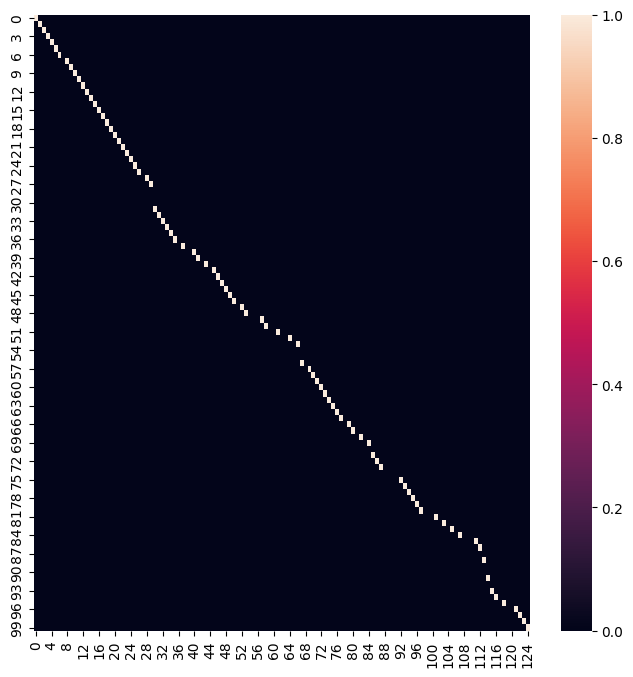

In [15]:
heatmap = np.zeros(shape=(TEST_EXAMPLE['m'].size, TEST_EXAMPLE['t'].size))
for mi, ti in matches:
    if mi is not None and ti is not None:
        heatmap[mi][ti] = 1

plt.figure(figsize=(8,8))
sns.heatmap(heatmap)

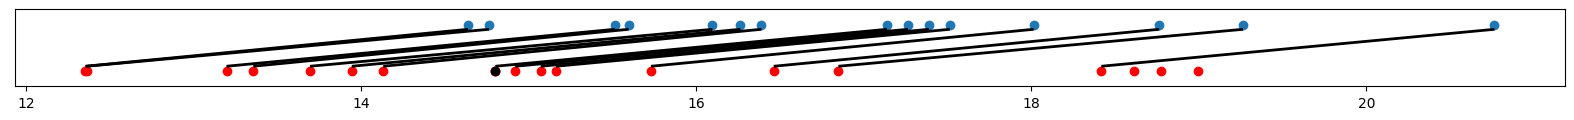

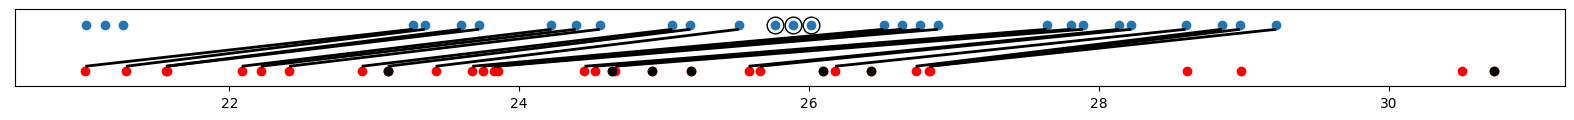

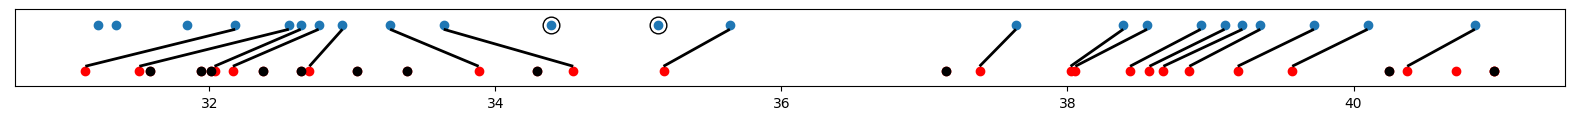

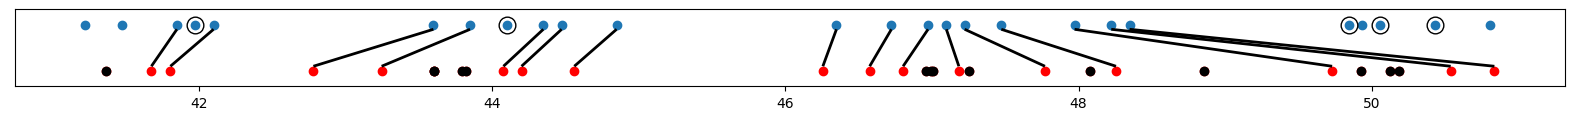

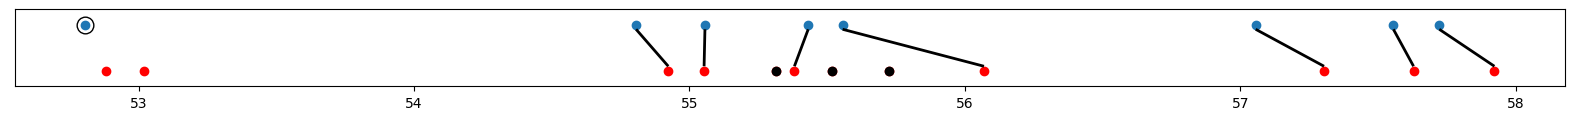

In [16]:
nbt.plot_matching_in_rows(centered_m, TEST_EXAMPLE['t'], matches)

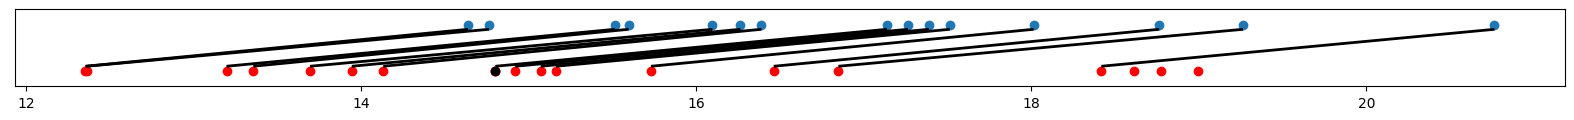

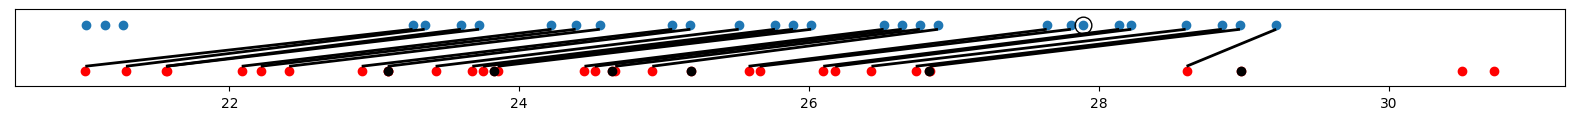

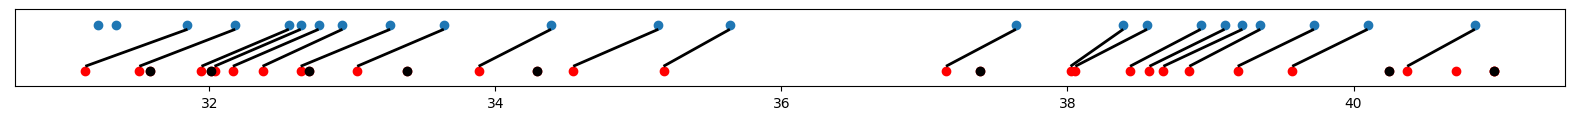

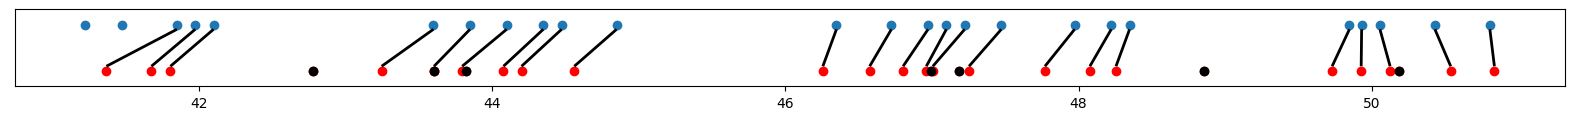

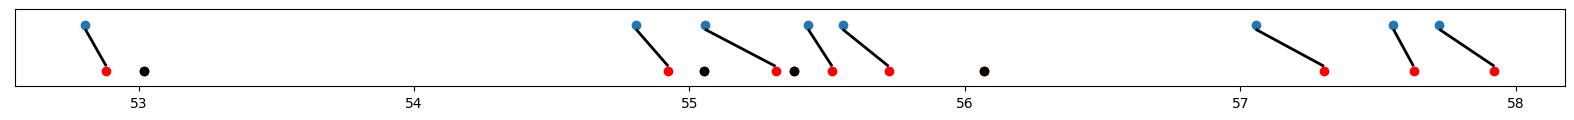

In [17]:
nbt.plot_matching_in_rows(centered_m, TEST_EXAMPLE['t'], TEST_EXAMPLE['matchings'])

# Algorithm Performance

In [18]:
times = []
jaccards = []
costs = []

for example in tqdm(train_examples):

    centered_m = vp.center_midi_on_transients(example['m'], example['t'])

    start_time = time.time()
    cost, matches = min_cost_match(centered_m, example['t'], example['m_diff'], example['t_diff'])
    end_time = time.time()

    times.append(end_time - start_time)
    jaccards.append(vp.score_matching(example['matchings'], matches))
    costs.append(cost)

algorithm_performance = pd.DataFrame({'time': times, 'jaccard': jaccards, 'cost': costs})
algorithm_performance.describe()

100%|██████████| 500/500 [02:49<00:00,  2.94it/s]


,time,jaccard,cost
count,500.000000,500.000000,500.000000
mean,0.339320,0.476994,20.383105
std,0.409172,0.195977,14.887668
min,0.003989,0.091837,2.431570
25%,0.027430,0.298788,8.460465
50%,0.152120,0.472598,16.659493
75%,0.478570,0.641043,27.919461
max,1.981703,0.924528,74.189228


In [19]:
plot_df = pd.concat([train_params, algorithm_performance], axis=1)
plot_df['total_error_rate'] = plot_df['deletion_rate'] + plot_df['insertion_rate'] + plot_df['space_augmentation_rate'] + plot_df['space_reduction_rate'] 

corr_matrix = plot_df.corr(method='spearman')
corr_matrix

,deletion_rate,insertion_rate,len_m,space_augmentation_rate,space_reduction_rate,time,jaccard,cost,total_error_rate
deletion_rate,1.000000,0.068669,-0.012115,-0.049648,-0.045274,-0.162925,-0.687275,0.341658,0.663298
insertion_rate,0.068669,1.000000,0.087070,-0.063909,-0.068510,0.188858,-0.546899,0.298546,0.673929
len_m,-0.012115,0.087070,1.000000,-0.061901,0.003556,0.965195,-0.053820,0.866702,0.040873
space_augmentation_rate,-0.049648,-0.063909,-0.061901,1.000000,0.023917,-0.058284,0.025370,-0.039698,0.043918
space_reduction_rate,-0.045274,-0.068510,0.003556,0.023917,1.000000,-0.008609,0.037288,-0.003590,0.041412
time,-0.162925,0.188858,0.965195,-0.058284,-0.008609,1.000000,0.000427,0.803373,0.007171
jaccard,-0.687275,-0.546899,-0.053820,0.025370,0.037288,0.000427,1.000000,-0.460340,-0.900745
cost,0.341658,0.298546,0.866702,-0.039698,-0.003590,0.803373,-0.460340,1.000000,0.471751
total_error_rate,0.663298,0.673929,0.040873,0.043918,0.041412,0.007171,-0.900745,0.471751,1.000000


<AxesSubplot: >

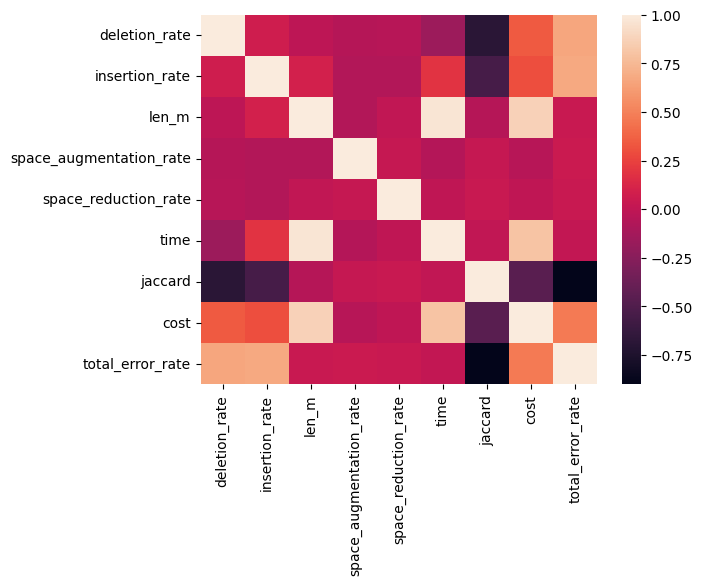

In [20]:
sns.heatmap(corr_matrix)

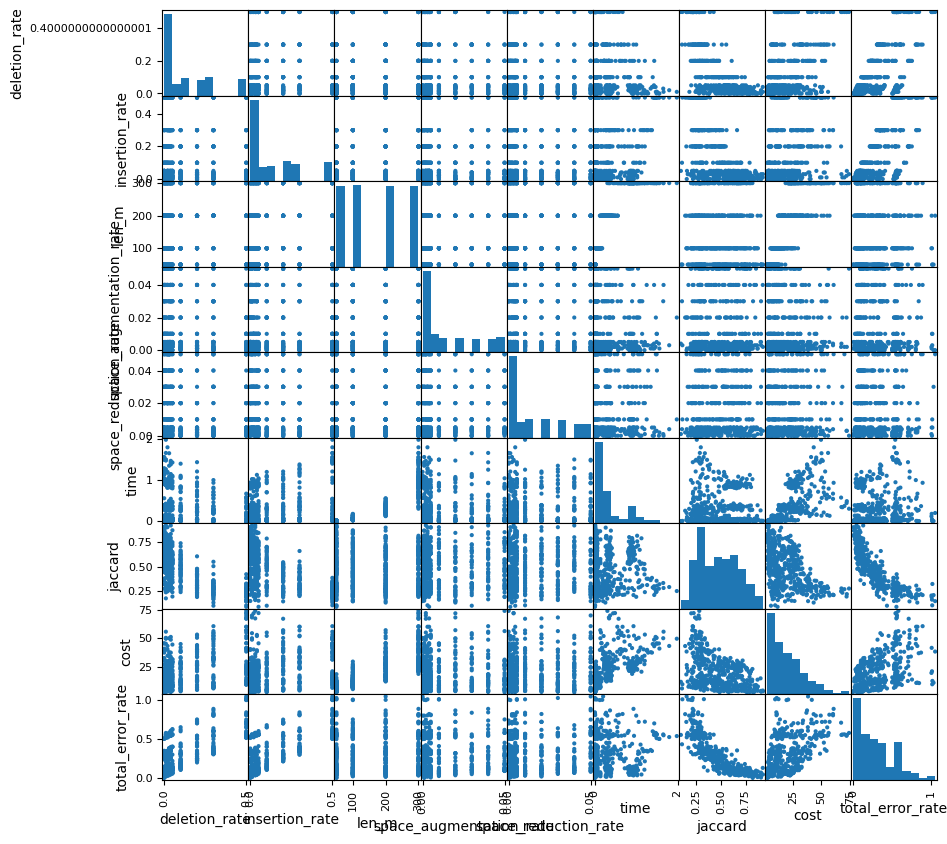

In [21]:
pd.plotting.scatter_matrix(plot_df, figsize=(10,10), alpha=1)
plt.show()